In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from scipy import sparse
from sklearn.metrics.pairwise import cosine_similarity
import pickle
import re
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import Ridge
from sklearn import linear_model
import time
import joblib

import matplotlib.pyplot as plt

# load data

In [3]:
df_train = pd.ExcelFile('crawl_data/train_data.xlsx', encoding= 'utf-8').parse('Sheet1')
df_test = pd.ExcelFile('crawl_data/test_data.xlsx', encoding= 'utf-8').parse('Sheet1')
df_train.head(2)

,id_train,mobile_number,target
0,0,855666666,5
1,1,356000000,5


In [4]:
df_train.shape

(476028, 3)

In [5]:
# preprocesing data
def check_mobile_number(mobile_number):
    '''
    input: (str) the mobile number
    output: bool
    '''
    if (len(mobile_number) == 9):
        # các đầu số di động của các nhà mạng ở Việt Nam 
        dau_so_di_dong = ['89', '90', '93', '70', '79', '77', '76', '78', '96', '97', '98', '86', '31', '32', 
                      '33', '34', '35', '36', '37', '38', '39', '88', '91', '94', '80', '81', '82', '83', 
                      '84', '85', '92', '56', '57', '58', '99', '19', '52', '59', '87', '95', '71', '72', 
                        '74','75']
        if mobile_number[:2] in dau_so_di_dong:
            return 1
        else:
            return 0
    else:
        return 0
df_train['check'] = df_train.mobile_number.astype('str').apply(check_mobile_number)
df_test['check'] = df_test.mobile_number.astype('str').apply(check_mobile_number)

In [6]:
df_train[df_train.check == 0]

,id_train,mobile_number,target,check
90625,90625,187078468,2,0
294061,294061,102117292,2,0


In [7]:
# clean data
df_test = df_test[df_test.check == 1]
df_test = df_test.reset_index()
df_test = df_test.drop(['index', 'id_test', 'check'], axis= 1)
df_test = df_test.reset_index()
df_test.columns = ['id_test', 'mobile_number', 'target']

df_train = df_train[df_train.check == 1]
df_train = df_train.reset_index()
df_train = df_train.drop(['index', 'id_train', 'check'], axis= 1)
df_train = df_train.reset_index()
df_train.columns = ['id_train', 'mobile_number', 'target']
df_train.shape

(476026, 3)

In [8]:
# n-gram
def generate_ngrams(text, n_gram= 2):
    text = str(text)
    token = [str(i) for i in text]
    #print(token)
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    #print(ngrams)
    ngrams1 = "|".join([" ".join(ngram) for ngram in ngrams])
    ngrams1 = re.sub('\s+', '', ngrams1)
    return ngrams1.strip()

# normalize mobile number
def norm_mobile_number(mobile_number):
    #  create a dictionary, convert dau so di dong
    convert_dau_so = {'162' : '32',
                    '163' : '33',
                    '164' : '34',
                    '165' : '35',
                    '166' : '36',
                    '167' : '37',
                    '168' : '38',
                    '169' : '39',
                    '120' : '70',
                    '121' : '79',
                    '122' : '77',
                    '126' : '76',
                    '128' : '78',
                    '123' : '83',
                    '124' : '84',
                    '125' : '85',
                    '127' : '81',
                    '129' :'82',
                    '199' : '59'}
    '''normalize mobile number (str)'''
    if mobile_number[0] == '0':
        mobile = mobile_number[1:]
    else:
        mobile = mobile_number
    if mobile[:3] in convert_dau_so.keys():
        mobile = convert_dau_so[mobile[:3]] + mobile[3:]
    return mobile

# create the index for the num_phrases

In [ ]:
# create index for the num_phrases
# bộ 6 số 
    # bộ 6 số cuối 
    # 000000, ..., 999999
luc = [str(i)*6 for i in range(0,10)] 
    # 012345, ..., 456789
so_tang6 = generate_ngrams('0123456789', n_gram= 6).split('|')
    # 987654, ..., 543210
so_giam6 = generate_ngrams('9876543210', n_gram= 6).split('|')
    # 141516, ...
cum_tang6 = ['ABAB+1AB+2']
    # 161514, ...
cum_giam6 = ['ABAB-1AB-2']
    # 686868, ...
lap6 = ['ABABAB']
    # bộ 6 số giữa. 'b' : between 
luc_b = [i+'b' for i in luc]
so_tang6b = [i+ 'b' for i in so_tang6]
so_giam6b = [i + 'b' for i in so_giam6]
# cum_tang6b = ['ABAB+1AB+2b']
# cum_giam6b = ['ABAB-1AB-2b']
lap6b = ['ABABABb']

bo_6= luc+ luc_b+ so_tang6+ so_tang6b+ so_giam6+ so_giam6b+ cum_tang6+ cum_giam6+ lap6+ lap6b

# bộ 5 số
    # bộ 5 số cuối
ngu = [str(i)*5 for i in range(0,10)]
so_tang5 = generate_ngrams('0123456789', n_gram= 5).split('|')
so_giam5 = generate_ngrams('9876543210', n_gram= 5).split('|')
ganh5 = ['ABCAB']
    # bộ 5 số giữa. 'b' : between 
ngu_b = [i + 'b' for i in ngu]
so_tang5b = [i + 'b' for i in so_tang5]
so_giam5b = [i + 'b' for i in so_giam5]

bo_5 = ngu + ngu_b + so_tang5 + so_tang5b + so_giam5 + so_giam5b + ganh5

# bộ 4 số  
    # bộ 4 số cuối
tu = [str(i)*4 for i in range(0,10)]
so_tang4 = generate_ngrams('0123456789', n_gram= 4).split('|')
so_giam4 = generate_ngrams('9876543210', n_gram= 4).split('|')
cum_tang4 = ['ABAB+1']
cum_giam4 = ['ABAB-1']
lap4 = ['ABAB']
    # bộ 4 số giữa. 'b' : between 
tu_b = [i+'b' for i in tu]
so_tang4b = [i+ 'b' for i in so_tang4]
so_giam4b = [i + 'b' for i in so_giam4]
# cum_tang4b = ['ABAB+1b']
# cum_giam4b = ['ABAB-1b']
lap4b = ['ABABb']

bo_4 = tu+ tu_b+ so_tang4+ so_tang4b+ so_giam4 + so_giam4b+ cum_tang4 + cum_giam4 + lap4 + lap4b
    
# bộ 3 số
    # bộ 3 số cuối
tam = [str(i)*3 for i in range(0,10)]
so_tang3 = generate_ngrams('0123456789', n_gram= 3).split('|')
so_giam3 = generate_ngrams('9876543210', n_gram= 3).split('|')
ganh3 = ['ABA']

    # bộ 3 số giữa. 'b' : between 
tam_b = [i + 'b' for i in tam]
so_tang3b = [i + 'b' for i in so_tang3]
# so_giam3b = [i + 'b' for i in so_giam3]
# ganh3b = ['ABAb']

bo_3 = tam + tam_b + so_tang3 + so_tang3b + so_giam3 + ganh3 

# bộ 2 số cuối đẹp 
# 'e': end
nhi = ['06', '09', '10', '12', '16', '17', '18', '19', '26', '28', '33',
   '36', '37', '38', '39', '40', '40', '46', '50', '52', '53', '56',
   '57', '66', '66', '68', '77', '78', '79', '80', '80', '83', '86',
   '86', '88', '89', '90', '92', '97']
nhi = [i + 'e' for i in nhi]

# bộ đầu số các nhà mạng
# 's': start
dau_so = ['89', '90', '93', '70', '79', '77', '76', '78', '96', '97', '98', '86', '31', '32', 
          '33', '34', '35', '36', '37', '38', '39', '88', '91', '94', '80', '81', '82', '83', 
          '84', '85', '92', '56', '57', '58', '99', '19', '52', '59', '87', '95', '71', '72', 
          '74', '75']
dau_so = [i+'s' for i in dau_so]

# biggram
biggram = ['00', '01', '02', '03', '04', '05', '06', '07', '08', '09'] + [str(i) for i in list(np.arange(10,100))]


In [ ]:
num_phrases= dau_so + biggram + nhi + bo_3 + bo_4 + bo_5 + bo_6

df_num = pd.DataFrame()
df_num['num_phrases'] = num_phrases
df_num_phrases = df_num.reset_index()
df_num_phrases.columns = ['id', 'num_phrases']

In [ ]:
# writer = pd.ExcelWriter('index_num_phrases_ver2.xlsx', engine='xlsxwriter')
# df_num_phrasewriter = pd.ExcelWriter('index_num_phrases_ver2.xlsx', engine='xlsxwriter')
# df_num_phrases.to_excel(writer, 'Sheet1', index= False, encoding= 'utf-8')
# writer.save()

# extract feature 

In [ ]:
# extract feature
def extract_feature(idx, mobile_number):
    '''
    input: (str) mobile number
    '''
    mobile = norm_mobile_number(mobile_number)
    # kiểm tra số điện thoại
    if check_mobile_number(mobile)== 0:
        return 0
    
     
    # create a DataFrame, contain the each mobile number infor
    df = pd.DataFrame()
    # thực hiện biggram cho 7 số cuối của chuỗi số điện thoại 
    df['num_phrases'] = generate_ngrams(mobile[2:], n_gram= 2).split('|')
    df = df.num_phrases.value_counts().to_frame()
    df = df.reset_index()
    df.columns = ['num_phrases', 'count']
    
        # xét 2 số đầu tiên của dãy số điện thoại 's': start
    so_dau = {'num_phrases':mobile[:2]+'s', 'count': 5}
    # -insert new row into dataframe 
    df = df.append(so_dau, ignore_index= True)
    
    # xét 2 số cuối của dãy số điện thoại(trường hợp riêng xét độc lập với trường hợp các bộ số đặc biệt)
    # bộ 2 số cuối đẹp 
    hai_so_cuoi  = ['06', '09', '10', '12', '16', '17', '18', '19', '26', '28', '33',
       '36', '37', '38', '39', '40', '40', '46', '50', '52', '53', '56',
       '57', '66', '66', '68', '77', '78', '79', '80', '80', '83', '86',
       '86', '88', '89', '90', '92', '97']
    if mobile[-2:] in hai_so_cuoi:
        # 'e': end
        so_cuoi_2 = {'num_phrases': mobile[-2:]+'e', 'count': 3}
        df = df.append(so_cuoi_2, ignore_index= True)
    
    # xét các bộ số đặc biệt trong chuỗi 7 số cuối 
    # bộ 6 số  
        # 000000, ..., 999999
    luc = [str(i)*6 for i in range(0,10)] 
        # 012345, ..., 456789
    so_tang6 = generate_ngrams('0123456789', n_gram= 6).split('|')
        # 987654, ..., 543210
    so_giam6 = generate_ngrams('9876543210', n_gram= 6).split('|')

    # bộ 5 số
        # bộ 5 số cuối
    ngu = [str(i)*5 for i in range(0,10)]
    so_tang5 = generate_ngrams('0123456789', n_gram= 5).split('|')
    so_giam5 = generate_ngrams('9876543210', n_gram= 5).split('|')

    # bộ 4 số  
        # bộ 4 số cuối
    tu = [str(i)*4 for i in range(0,10)]
    so_tang4 = generate_ngrams('0123456789', n_gram= 4).split('|')
    so_giam4 = generate_ngrams('9876543210', n_gram= 4).split('|')

    # bộ 3 số
        # bộ 3 số cuối
    tam = [str(i)*3 for i in range(0,10)]
    so_tang3 = generate_ngrams('0123456789', n_gram= 3).split('|')
    so_giam3 = generate_ngrams('9876543210', n_gram= 3).split('|')
    ganh3 = ['ABA']

    # bộ 6 số giữa và cuoi
        # nếu 6 số cuối là bộ số luc: 000000, ..., 999999
    if mobile[-6:] in luc:
        so_cuoi = {'num_phrases': mobile[-6:], 'count': 5}
        df = df.append(so_cuoi, ignore_index= True)
        # nếu 6 số giữa là bộ số luc: 000000, ..., 999999
        if mobile[2:-1] in luc:
            # 'b': between
            so_giua = {'num_phrases': mobile[2:-1]+ 'b', 'count': 5}
            df = df.append(so_giua, ignore_index= True)
        
        # 012345, ..., 456789
    elif mobile[-6:] in so_tang6:
        so_cuoi = {'num_phrases': mobile[-6:], 'count': 5}
        df = df.append(so_cuoi, ignore_index= True)
        # 012345, ..., 456789, 'b': between
        if mobile[2:-1] in so_tang6:
            so_giua = {'num_phrases': mobile[2:-1] + 'b', 'count': 5}
            df = df.append(so_giua, ignore_index= True)
        # 987654, ..., 543210
    elif mobile[-6:] in so_giam6:
        so_cuoi = {'num_phrases': mobile[-6:], 'count': 5}
        df = df.append(so_cuoi, ignore_index= True)
         # 987654, ..., 543210, 'b': between
        if mobile[2:-1] in so_giam6:
            so_giua = {'num_phrases': mobile[2:-1] + 'b', 'count': 5}
            df = df.append(so_giua, ignore_index= True)
        # cum so tang dan: ABAB+1AB+2
    elif(int(mobile[-6:-4]) == int(mobile[-4:-2]) - 1) and (int(mobile[-6:-4]) == int(mobile[-2:]) - 2):
        so_cuoi = {'num_phrases': 'ABAB+1AB+2', 'count': 5}
        df = df.append(so_cuoi, ignore_index= True)
        # cum so giam dan: ABAB-1AB-2
    elif(int(mobile[-6:-4]) == int(mobile[-4:-2]) + 1) and (int(mobile[-6:-4]) == int(mobile[-2:]) + 2):
        so_cuoi = {'num_phrases': 'ABAB-1AB-2', 'count': 5}
        df = df.append(so_cuoi, ignore_index= True)
        # cac bo so lap 6: ABABAB
    elif (mobile[-6:-4] == mobile[-4:-2]) and (mobile[-6:-4] == mobile[-2:]):
        so_cuoi = {'num_phrases': 'ABABAB', 'count': 5}
        df = df.append(so_cuoi, ignore_index= True)
        # cac bo so lap 6: ABABAB
        if (mobile[2:4] == mobile[4:6]) and (mobile[2:4] == mobile[6:8]):
            so_giua = {'num_phrases': 'ABABABb', 'count': 5}
            df = df.append(so_giua, ignore_index= True)
        
        
    # bộ 5 số cuối 
        # nếu 5 số cuối là bộ số luc: 00000, ..., 99999
    elif mobile[-5:] in ngu:
        so_cuoi = {'num_phrases': mobile[-5:], 'count': 5}
        df = df.append(so_cuoi, ignore_index= True)
        # xet cum so giua
        if mobile[2:5] in so_tang3:
            so_giua = {'num_phrases': mobile[2:5] + 'b', 'count': 5}
            df = df.append(so_giua, ignore_index= True)
        # 01234, ..., 56789
    elif mobile[-5:] in so_tang5:
        so_cuoi = {'num_phrases': mobile[-5:], 'count': 5}
        df = df.append(so_cuoi, ignore_index= True)
        # xet cum so giua
        if mobile[2:5] in tam:
            so_giua = {'num_phrases': mobile[2:5] + 'b', 'count': 5}
            df = df.append(so_giua, ignore_index= True)
        # 98765, ..., 43210
    elif mobile[-5:] in so_giam5:
        so_cuoi = {'num_phrases': mobile[-5:], 'count': 5}
        df = df.append(so_cuoi, ignore_index= True)
        # xet cum so giua
        if mobile[2:5] in tam:
            so_giua = {'num_phrases': mobile[2:5] + 'b', 'count': 5}
            df = df.append(so_giua, ignore_index= True)
        # cac bo so ganh 5: ABCAB
    elif (mobile[-5:-3] == mobile[-2:]):
        so_cuoi = {'num_phrases': 'ABCAB', 'count': 5}
        df = df.append(so_cuoi, ignore_index= True)
        # xet cum giua 
        if mobile[2:6] in tu:
            so_giua = {'num_phrases': mobile[2:6] + 'b', 'count': 5}
            df = df.append(so_giua, ignore_index= True)
        elif mobile[2:4] == mobile[4:6]:
            so_giua = {'num_phrases': 'ABABb', 'count': 5}
            df = df.append(so_giua, ignore_index= True)
        # xe cum 4
        else:
            ls_num = so_tang5+ so_giam5 + tu + so_tang4 + so_giam4 + tam + so_tang3
            for num in ls_num:
                if num in mobile[2:6]:
                    so_giua = {'num_phrases': num + 'b', 'count': 5}
                    df = df.append(so_giua, ignore_index= True)
                    break
        
    # bộ 4 số cuối 
         # nếu 4 số cuối là bộ số 4 chữ số: 0000, ..., 999
    elif mobile[-4:] in tu:
        so_cuoi = {'num_phrases': mobile[-4:], 'count': 5}
        df = df.append(so_cuoi, ignore_index= True)
        # xet cum giua
        if mobile[2:4] == mobile[4:6]:
            so_giua = {'num_phrases': 'ABABb', 'count': 5}
            df = df.append(so_giua, ignore_index= True)
        else:
            ls_num =so_tang4 + so_giam4 + tam + so_tang3
            for num in ls_num:
                if num in mobile[2:6]:
                    so_giua = {'num_phrases': num + 'b', 'count': 5}
                    df = df.append(so_giua, ignore_index= True)
                    break
        # 01234, ..., 56789
    elif mobile[-4:] in so_tang4:
        so_cuoi = {'num_phrases': mobile[-4:], 'count': 5}
        df = df.append(so_cuoi, ignore_index= True)
        # xet cum giua
        if mobile[2:6] in tu:
            so_giua = {'num_phrases': mobile[2:6] + 'b', 'count': 5}
            df = df.append(so_giua, ignore_index= True)
        elif (mobile[2:4] == mobile[4:6]) or (mobile[4:6] == mobile[6:-1]) or (mobile[3:5] == mobile[5:7]):
            so_giua = {'num_phrases': 'ABABb', 'count': 5}
            df = df.append(so_giua, ignore_index= True)
        else:
            ls_num = so_giam4 + tam + so_tang3
            for num in ls_num:
                if num in mobile[2:6]:
                    so_giua = {'num_phrases': num + 'b', 'count': 5}
                    df = df.append(so_giua, ignore_index= True)
                    break
        # 01234, ..., 56789
    elif mobile[-4:] in so_giam4:
        so_cuoi = {'num_phrases': mobile[-4:], 'count': 5}
        df = df.append(so_cuoi, ignore_index= True)
        # xet cum giua
        if mobile[2:6] in tu:
            so_giua = {'num_phrases': mobile[2:6] + 'b', 'count': 5}
            df = df.append(so_giua, ignore_index= True)
        elif (mobile[2:4] == mobile[4:6]) or (mobile[4:6] == mobile[6:-1]) or (mobile[3:5] == mobile[5:7]):
            so_giua = {'num_phrases': 'ABABb', 'count': 5}
            df = df.append(so_giua, ignore_index= True)
        else:
            ls_num =  so_tang4 + tam + so_tang3
            for num in ls_num:
                if num in mobile[2:6]:
                    so_giua = {'num_phrases': num + 'b', 'count': 5}
                    df = df.append(so_giua, ignore_index= True)
                    break
        # cum so tang 'ABAB+1'
    elif(int(mobile[-4:-2]) ==  int(mobile[-2:]) - 1):
        so_cuoi = {'num_phrases': 'ABAB+1', 'count': 5}
        df = df.append(so_cuoi, ignore_index= True)
        # xet cum giua
        if mobile[2:6] in tu:
            so_giua = {'num_phrases': mobile[2:6] + 'b', 'count': 5}
            df = df.append(so_giua, ignore_index= True)
        elif (mobile[2:4] == mobile[4:6]) or (mobile[4:6] == mobile[6:-1]) or (mobile[3:5] == mobile[5:7]):
            so_giua = {'num_phrases': 'ABABb', 'count': 5}
            df = df.append(so_giua, ignore_index= True)
        else:
            ls_num = so_tang5 + so_giam5+ so_tang4 + so_giam4 + tam + so_tang3
            for num in ls_num:
                if num in mobile[2:-1]:
                    so_giua = {'num_phrases': num + 'b', 'count': 5}
                    df = df.append(so_giua, ignore_index= True)
                    break
        # cum so giam 'ABAB-1'
    elif(int(mobile[-4:-2]) ==  int(mobile[-2:]) + 1):
        so_cuoi = {'num_phrases': 'ABAB-1', 'count': 5}
        df = df.append(so_cuoi, ignore_index= True)
        # xet cum giua
        if mobile[2:6] in tu:
            so_giua = {'num_phrases': mobile[2:6] + 'b', 'count': 5}
            df = df.append(so_giua, ignore_index= True)
        elif (mobile[2:4] == mobile[4:6]) or (mobile[4:6] == mobile[6:-1]) or (mobile[3:5] == mobile[5:7]):
            so_giua = {'num_phrases': 'ABABb', 'count': 5}
            df = df.append(so_giua, ignore_index= True)
        else:
            ls_num = so_tang5 + so_giam5 + so_tang4 + so_giam4 + tam + so_tang3
            for num in ls_num:
                if num in mobile[2:-1]:
                    so_giua = {'num_phrases': num + 'b', 'count': 5}
                    df = df.append(so_giua, ignore_index= True)
                    break
        # cac bo so lap 4: ABAB
    elif (mobile[-4:-2] == mobile[-2:]):
        so_cuoi = {'num_phrases': 'ABAB', 'count': 5}
        df = df.append(so_cuoi, ignore_index= True)
        # xet cum giua
        if mobile[2:6] in tu:
            so_giua = {'num_phrases': mobile[2:6] + 'b', 'count': 5}
            df = df.append(so_giua, ignore_index= True)
        elif (mobile[2:4] == mobile[4:6]) or (mobile[4:6] == mobile[6:-1]) or (mobile[3:5] == mobile[5:7]):
            so_giua = {'num_phrases': 'ABABb', 'count': 5}
            df = df.append(so_giua, ignore_index= True)
        else:
            ls_num = so_tang5 + so_giam5 + so_tang4 + so_giam4 + tam + so_tang3
            for num in ls_num:
                if num in mobile[2:-1]:
                    so_giua = {'num_phrases': num + 'b', 'count': 5}
                    df = df.append(so_giua, ignore_index= True)
                    break
    
    # bộ 3 số cuối 
        # nếu 3 số cuối là bộ số luc: 000, ..., 999
    elif mobile[-3:] in tam:
        so_cuoi = {'num_phrases': mobile[-3:], 'count': 5}
        df = df.append(so_cuoi, ignore_index= True)
        # xet cum giua
        if mobile[2:6] in tu:
            so_giua = {'num_phrases': mobile[2:6] + 'b', 'count': 5}
            df = df.append(so_giua, ignore_index= True)
        elif (mobile[2:4] == mobile[4:6]) or (mobile[3:5] == mobile[5:7]):
            so_giua = {'num_phrases': 'ABABb', 'count': 5}
            df = df.append(so_giua, ignore_index= True)
        else:
            ls_num = so_tang5 + so_giam5 + so_tang4 + so_giam4 + tam + so_tang3
            for num in ls_num:
                if num in mobile[2:7]:
                    so_giua = {'num_phrases': num + 'b', 'count': 5}
                    df = df.append(so_giua, ignore_index= True)
                    break

        # 012, ..., 789
    elif mobile[-3:] in so_tang3:
        so_cuoi = {'num_phrases': mobile[-3:], 'count': 5}
        df = df.append(so_cuoi, ignore_index= True)
        # xet cum giua
        if mobile[2:7] in ngu:
            so_giua = {'num_phrases': mobile[2:7] + 'b', 'count': 5}
            df = df.append(so_giua, ignore_index= True)
        elif mobile[2:6] in tu:
            so_giua = {'num_phrases': mobile[2:6] + 'b', 'count': 5}
            df = df.append(so_giua, ignore_index= True)
        elif (mobile[2:4] == mobile[4:6]) or (mobile[4:6] == mobile[6:-1]) or (mobile[3:5] == mobile[5:7]):
            so_giua = {'num_phrases': 'ABABb', 'count': 5}
            df = df.append(so_giua, ignore_index= True)
        else:
            ls_num = so_tang5 + so_giam5 + so_tang4 + so_giam4 + tam + so_tang3
            for num in ls_num:
                if num in mobile[2:8]:
                    so_giua = {'num_phrases': num + 'b', 'count': 5}
                    df = df.append(so_giua, ignore_index= True)
                    break
    elif mobile[-3:] in so_giam3:
        so_cuoi = {'num_phrases': mobile[-3:], 'count': 5}
        df = df.append(so_cuoi, ignore_index= True)
        # xet cum giua
        if mobile[2:7] in ngu:
            so_giua = {'num_phrases': mobile[2:7] + 'b', 'count': 5}
            df = df.append(so_giua, ignore_index= True)
        elif mobile[2:6] in tu:
            so_giua = {'num_phrases': mobile[2:6] + 'b', 'count': 5}
            df = df.append(so_giua, ignore_index= True)
        elif (mobile[2:4] == mobile[4:6]) or (mobile[4:6] == mobile[6:-1]) or (mobile[3:5] == mobile[5:7]):
            so_giua = {'num_phrases': 'ABABb', 'count': 5}
            df = df.append(so_giua, ignore_index= True)
        else:
            ls_num = so_tang5 + so_giam5 + so_tang4 + so_giam4 + tam + so_tang3
            for num in ls_num:
                if num in mobile[2:8]:
                    so_giua = {'num_phrases': num + 'b', 'count': 5}
                    df = df.append(so_giua, ignore_index= True)
                    break
        # cac bo so ganh 5: ABCAB
    elif (mobile[-3] == mobile[-1]):
        so_cuoi = {'num_phrases': 'ABA', 'count': 5}
        df = df.append(so_cuoi, ignore_index= True)
        # xet cum giua
        if mobile[2:7] in ngu:
            so_giua = {'num_phrases': mobile[2:7] + 'b', 'count': 5}
            df = df.append(so_giua, ignore_index= True)
        elif mobile[2:6] in tu:
            so_giua = {'num_phrases': mobile[2:6] + 'b', 'count': 5}
            df = df.append(so_giua, ignore_index= True)
        elif (mobile[2:4] == mobile[4:6]) or (mobile[4:6] == mobile[6:-1]) or (mobile[3:5] == mobile[5:7]):
            so_giua = {'num_phrases': 'ABABb', 'count': 5}
            df = df.append(so_giua, ignore_index= True)
        else:
            ls_num = so_tang5 + so_giam5 + so_tang4 + so_giam4 + tam + so_tang3
            for num in ls_num:
                if num in mobile[2:8]:
                    so_giua = {'num_phrases': num + 'b', 'count': 5}
                    df = df.append(so_giua, ignore_index= True)
                    break
    # xét cụm 6 số ở giữa. khi các số cuối không đặc biệt
    else:
        if mobile[2:8] in luc:
            so_giua = {'num_phrases': mobile[2:8] + 'b', 'count': 5}
            df = df.append(so_giua, ignore_index= True)
        elif (mobile[2:7] in ngu) or (mobile[3:8] in ngu):
            if mobile[2:7] in ngu:
                so_giua = {'num_phrases': mobile[2:7] + 'b', 'count': 5}
                df = df.append(so_giua, ignore_index= True)
            elif mobile[3:8] in ngu:
                so_giua = {'num_phrases': mobile[3:8] + 'b', 'count': 5}
                df = df.append(so_giua, ignore_index= True)
        elif (mobile[2:6] in tu) or (mobile[3:7] in tu) or (mobile[4:8] in tu):
            if mobile[2:6] in tu:
                so_giua = {'num_phrases': mobile[2:6] + 'b', 'count': 5}
                df = df.append(so_giua, ignore_index= True)
            elif mobile[3:7] in tu:
                so_giua = {'num_phrases': mobile[3:7] + 'b', 'count': 5}
                df = df.append(so_giua, ignore_index= True)
            elif mobile[4:8] in tu:
                so_giua = {'num_phrases': mobile[4:8] + 'b', 'count': 5}
                df = df.append(so_giua, ignore_index= True)
        # cac bo so lap 6: ABABAB
        elif (mobile[2:4] == mobile[4:6]) and (mobile[2:4] == mobile[6:8]):
            so_giua = {'num_phrases': 'ABABABb', 'count': 5}
            df = df.append(so_giua, ignore_index= True)
        # cac bo so lap 6: ABAB
        elif (mobile[2:4] == mobile[4:6]) or (mobile[4:6] == mobile[6:8]) or (mobile[3:5] == mobile[5:7]):
            so_giua = {'num_phrases': 'ABABb', 'count': 5}
            df = df.append(so_giua, ignore_index= True)
        else:
            ls_num = so_tang6+ so_tang6+ so_tang5+ so_giam5+ so_tang4+ so_giam4+ tam+ so_tang3
            for num in ls_num:
                if num in mobile[2:8]:
                    so_giua = {'num_phrases': num + 'b', 'count': 5}
                    df = df.append(so_giua, ignore_index= True)
                    break

    df['id'] = idx
    df = df[['id', 'num_phrases', 'count']]
    return df# extract feature

In [ ]:
ls_data_train = []
for i in range(df_train.shape[0]):
    ls_data_train.append(extract_feature(int(df_train.loc[i, 'id_train']), str(df_train.loc[i, 'mobile_number'])))

In [ ]:
ls_data_test = []
for i in range(df_test.shape[0]):
    ls_data_test.append(extract_feature(int(df_test.loc[i, 'id_test']), str(df_test.loc[i, 'mobile_number'])))

In [ ]:
df_feature_train = pd.concat(ls_data_train, axis = 0)
df_feature_test = pd.concat(ls_data_test, axis= 0)

In [ ]:
df_feature_train = df_feature_train.reset_index()
df_feature_train = df_feature_train.drop('index', axis= 1)
# merge index of the biggram and special number phrases in the feature dataframe
df_feature_test = pd.merge(df_feature_test, df_num_phrases, on= 'num_phrases', how= 'left')
df_feature_train = pd.merge(df_feature_train, df_num_phrases, on= 'num_phrases', how= 'left')

In [ ]:
# setup columns in the feature dataframe
df_feature_test = df_feature_test[['id_x', 'id_y', 'count', 'num_phrases']]
df_feature_test['id_x'] = df_feature_test['id_x'].astype('int')
df_feature_test.id_y = df_feature_test.id_y.astype('int')
df_feature_test.columns = ['id', 'id_num', 'count', 'num_phrases']

df_feature_train = df_feature_train[['id_x', 'id_y', 'count', 'num_phrases']]
df_feature_train['id_x'] = df_feature_train['id_x'].astype('int')
df_feature_train.id_y = df_feature_train.id_y.astype(int)
df_feature_train.columns = ['id', 'id_num', 'count', 'num_phrases']

# create feature matrix of phone number

In [ ]:
feature_train = df_feature_train[['id', 'id_num', 'count']].as_matrix()
feature_test = df_feature_test[['id', 'id_num', 'count']].as_matrix()
feature_train[-2:]

In [ ]:
n_row_train = max(df_feature_train['id']) + 1
n_row_test = max(df_feature_test['id']) + 1
n_col = max(df_feature_train['id_num']) + 1
print(n_row_train)
print(n_row_test)
print(n_col)

In [ ]:
X_train_sparse_csr = sparse.csr_matrix((feature_train[:, 2],(feature_train[:,0],feature_train[:,1])),(n_row_train,n_col))
X_test_sparse_csr = sparse.csr_matrix((feature_test[:, 2], (feature_test[:, 0], feature_test[:, 1])),(n_row_test, n_col))

In [ ]:
# # save sparse matrix
# joblib.dump(X_train_sparse_csr, 'X_sparse_train_ver2.pkl')
# joblib.dump(X_test_sparse_csr, 'X_sparse_test_ver2.pkl')

In [9]:
X_train_sparse_csr = joblib.load('feature_vector/X_sparse_train_ver2.pkl')
X_test_sparse_csr = joblib.load('feature_vector/X_sparse_test_ver2.pkl')

# visualize result

In [25]:
def compare_result(dictReportTrain, dictReportTest):
    
    # label set
    lsTarget = [str(i) for i in np.sort(list(set(y_train)))]
    # create a dataframe, contain the result of train test
    df_result = pd.DataFrame(columns= ['target', 'f-1 train', 'f-1 test'])
    
    for key in lsTarget:
        # convert float number
        dict_i = {'target':key, 
                  'f-1 train':float("{:10.2f}".format(dictReportTrain[key]['f1-score']*100)), 
                  'f-1 test':float("{:10.2f}".format(dictReportTest[key]['f1-score']*100))}
        df_result = df_result.append(dict_i, ignore_index=True)
    #df_result = df_result.reset_index()
    #df_result = df_result.drop('index', axis= 1)
    dict_mircro = {'target':'accuracy', 
                  'f-1 train':float("{:10.2f}".format(dictReportTrain['accuracy']*100)), 
                  'f-1 test':float("{:10.2f}".format(dictReportTest['accuracy']*100))}
    
    df_result = df_result.append(dict_mircro, ignore_index= True)
    
    plt.figure(figsize= (15,7))
    plt.plot(df_result.index, df_result['f-1 train'].values,'ob-', label='f-1 score in the train data')
    plt.plot(df_result.index, df_result['f-1 test'].values,'or-', label='f-1 score in the test data')
    plt.yticks(fontsize = 13)
    plt.xticks(df_result.index, df_result.target, rotation = 0, fontsize = 15)
    # Create legend
    plt.legend(ncol=len(df_result.index.values), bbox_to_anchor=(0, 1),
                  loc='lower left', fontsize=15)
    plt.ylabel('Ratio correct predict', fontsize = 20, color= "k")
    plt.xlabel('Target \n\n\nration correct prediction in the train and test data follow', fontsize = 20, color= "k")
    
    plt.yticks(range(0, 110, 10))
    # Show graphic
    plt.grid()
    plt.tight_layout()
    #plt.savefig('report/report1.png')
    plt.show()
    #return df_result

# Random forest

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,confusion_matrix
from sklearn import metrics

In [12]:
y_train = df_train.target.values
y_test = df_test.target.values

In [13]:
classifier = RandomForestClassifier(n_estimators = 1000, max_depth= 20, min_samples_split= 10, min_samples_leaf= 10, n_jobs= -1 )
classifier.fit(X_train_sparse_csr, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=20, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [14]:
y_pred = classifier.predict(X_train_sparse_csr)
    # outcome is dictionary: output_dict= True
dictReportTrain = classification_report(y_pred = y_pred, y_true= y_train, output_dict= True)
print(classification_report(y_pred = y_pred, y_true= y_train))

              precision    recall  f1-score   support

           0       0.78      0.23      0.36     40004
           1       1.00      0.00      0.00     20266
           2       0.59      0.95      0.73    215737
           3       0.73      0.44      0.55    159995
           4       0.78      0.26      0.39     29010
           5       0.89      0.59      0.71     11014

    accuracy                           0.63    476026
   macro avg       0.79      0.41      0.46    476026
weighted avg       0.69      0.63      0.58    476026



In [17]:
y_pred = classifier.predict(X_test_sparse_csr)
    # outcome is dictionary: output_dict= True
dictReportTest = classification_report(y_pred = y_pred, y_true= y_test, output_dict= True)
print(classification_report(y_pred = y_pred, y_true= y_test))

              precision    recall  f1-score   support

           0       0.78      0.24      0.36      9934
           1       0.00      0.00      0.00      5004
           2       0.59      0.95      0.72     54175
           3       0.73      0.44      0.54     40017
           4       0.75      0.24      0.37      7188
           5       0.89      0.58      0.70      2690

    accuracy                           0.63    119008
   macro avg       0.62      0.41      0.45    119008
weighted avg       0.64      0.63      0.58    119008



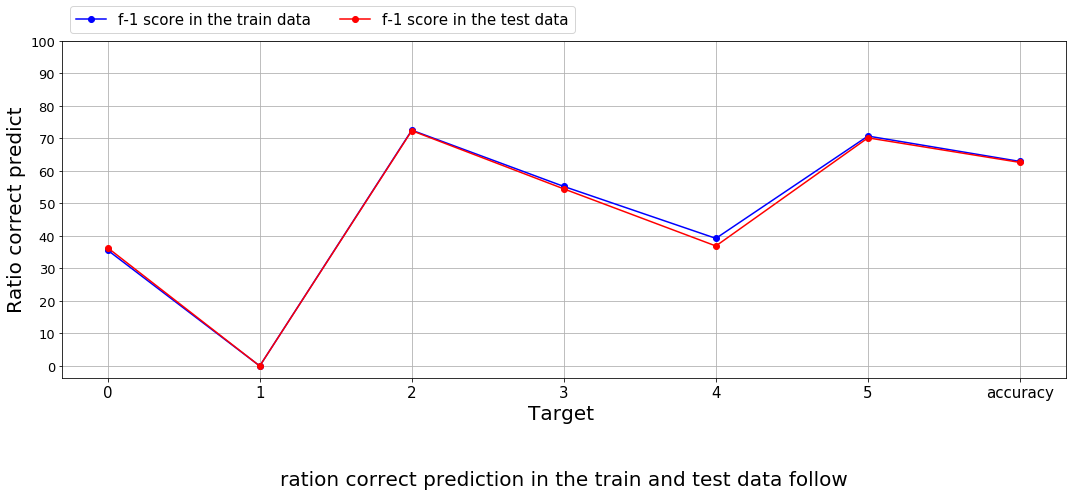

In [26]:
compare_result(dictReportTrain, dictReportTest)

In [ ]:
classifier = RandomForestClassifier(n_estimators = 1000, min_samples_split= 10, min_samples_leaf= 10, n_jobs= -1 )
classifier.fit(X_train_sparse_csr, y_train)

In [ ]:
y_pred0 = classifier.predict(X_train_sparse_csr)
    # outcome is dictionary: output_dict= True
dictReportTrain = classification_report(y_pred = y_pred0, y_true= y_train, output_dict= True)
print(classification_report(y_pred = y_pred0, y_true= y_train))

In [ ]:
y_pred0 = classifier.predict(X_test_sparse_csr)
    # outcome is dictionary: output_dict= True
dictReportTest = classification_report(y_pred = y_pred0, y_true= y_test, output_dict= True)
print(classification_report(y_pred = y_pred0, y_true= y_test))

In [ ]:
compare_result(dictReportTrain, dictReportTest)

In [ ]:
classifier1 = RandomForestClassifier(n_estimators = 1000, min_samples_split= 10, min_samples_leaf= 10, n_jobs= -1 )
classifier1.fit(X_train_sparse_csr, y_train)

In [ ]:
y_pred1 = classifier1.predict(X_train_sparse_csr)
    # outcome is dictionary: output_dict= True
dictReportTrain1 = classification_report(y_pred = y_pred1, y_true= y_train, output_dict= True)
print(classification_report(y_pred = y_pred1, y_true= y_train))


In [ ]:
y_pred1 = classifier1.predict(X_test_sparse_csr)
dictReportTest1 = classification_report(y_pred = y_pred1, y_true= y_test, output_dict= True)
print(classification_report(y_pred = y_pred1, y_true= y_test))

In [ ]:
compare_result(dictReportTrain1, dictReportTest1)

In [ ]:
joblib.dump(classifier1, 'random_forest_ver2.pkl')

In [ ]:
classifier2 = RandomForestClassifier(n_estimators = 369, min_samples_split= 3, min_samples_leaf= 3, n_jobs= -1 )
classifier2.fit(X_train_sparse_csr, y_train)

In [ ]:
y_pred2 = classifier2.predict(X_train_sparse_csr)
dictReportTrain2 = classification_report(y_pred = y_pred2, y_true= y_train, output_dict= True)
print(classification_report(y_pred = y_pred2, y_true= y_train))

In [ ]:
y_pred2 = classifier2.predict(X_test_sparse_csr)
dictReportTest2 = classification_report(y_pred = y_pred2, y_true= y_test, output_dict= True)
print(classification_report(y_pred = y_pred2, y_true= y_test))

In [ ]:
compare_result(dictReportTrain2, dictReportTest2)

In [ ]:
classifier3 = RandomForestClassifier(n_estimators = 369, min_samples_split= 2, min_samples_leaf= 2, n_jobs= -1 )
classifier3.fit(X_train_sparse_csr, y_train)

In [ ]:
y_pred3 = classifier3.predict(X_train_sparse_csr)
dictReportTrain3 = classification_report(y_pred = y_pred3, y_true= y_train, output_dict= True)
print(classification_report(y_pred = y_pred3, y_true= y_train))

In [ ]:
y_pred3 = classifier3.predict(X_test_sparse_csr)
dictReportTest3 = classification_report(y_pred = y_pred3, y_true= y_test, output_dict= True)
print(classification_report(y_pred = y_pred3, y_true= y_test))

In [ ]:
compare_result(dictReportTrain3, dictReportTest3)

# neural network

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import optimizers
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

In [ ]:
!pip install tensorflow

In [ ]:
set(y_train)

In [ ]:
## one hot encoding
# # define example
# data = ['cold', 'cold', 'warm', 'cold', 'hot', 'hot', 'warm', 'cold', 'warm', 'hot']
# values = array(data)
# print(values)
# # integer encode
# label_encoder = LabelEncoder()
# integer_encoded = label_encoder.fit_transform(values)
# print(integer_encoded)
# # binary encode
# onehot_encoder = OneHotEncoder(sparse=False)
# integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
# onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
# print(onehot_encoded)
# # invert first example
# inverted = label_encoder.inverse_transform([argmax(onehot_encoded[0, :])])
# print(inverted)

In [ ]:
# binary encode
# train
print(y_train.shape)
print(y_train[:5])
onehot_encoder = OneHotEncoder(sparse=False)
y_train = y_train.reshape(len(y_train), 1)
y_train_onehot = onehot_encoder.fit_transform(y_train)
print(y_train_onehot.shape)
print(y_train_onehot[:5])

# test
print(y_test.shape)
print(y_test[:5])
y_test = y_test.reshape(len(y_test), 1)
y_test_onehot = onehot_encoder.fit_transform(y_test)
print(y_test_onehot.shape)
print(y_test_onehot[:5])

In [ ]:
# # create neural network model
model = Sequential()
model.add(Dense(128, input_dim=X_train_sparse_csr.shape[1], activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
# we have 6 output
model.add(Dense(6 , activation='sigmoid'))

# in the classification problem have the many class,  use: loss='categorical_crossentropy'
# in the classification problem have the 2 class, use: loss='binary_crossentropy'
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

# bien save model
check_point = ModelCheckpoint('neural_network.h5', monitor='val_loss', save_best_only=True)

# label format is onehot encoding
model.fit(X_train_sparse_csr.todense(), y_train_onehot,
          epochs=20,
          validation_split=0.1,
          callbacks= [ check_point],
          batch_size=10)